In [1]:
!pip install pennylane --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 60.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 59.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 48.8 MB/s eta 0:00:00


In [2]:
import pennylane as qml
import pennylane.numpy as np
import matplotlib.pyplot as plt

### Exercise 1: Gates and circuits

Create and draw the following circuit using a QNode in pennylane:

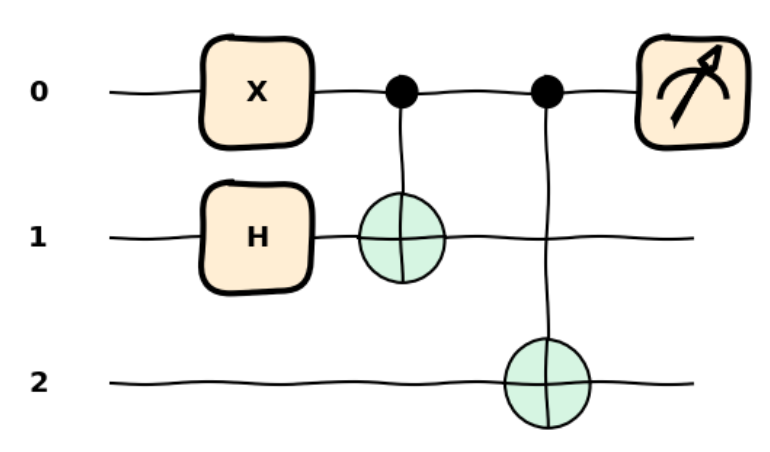

#### Solution

In [3]:
dev = qml.device("lightning.qubit", wires=3)

@qml.qnode(dev)
def exercise_circuit():
    qml.PauliX(wires=0)
    qml.Hadamard(wires=1)
    qml.CNOT(wires=[0,1])
    qml.CNOT(wires=[1,2])
    return qml.expval(qml.PauliZ(0))

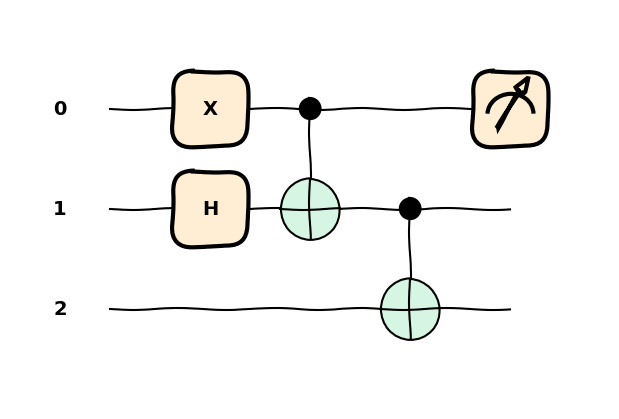

In [4]:
qml.draw_mpl(exercise_circuit, decimals=1, style="sketch")()
plt.show()

### Exercise 2: Gates and circuits

Write a circuit to create the three qubit [GHZ state](https://en.wikipedia.org/wiki/Greenberger–Horne–Zeilinger_state)
$$\frac{\big|\ 000\big> +\big|\ 111\big>}{\sqrt{2}}.$$

Then measure all qubits in the Z basis and simulate the circuit with 1000 shots and verify that the outcome is what you expect.

#### Solution

The GHZ state can be created from the Bell state by adding a third qubit and entangling it with a CNOT gate.

Here we want to measure all qubits.

In [5]:
exercise_dev = qml.device("lightning.qubit", wires=3, shots=1000)

@qml.qnode(exercise_dev)
def exercise_circuit():
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0,1])
    qml.CNOT(wires=[1,2])
    return [qml.sample(qml.PauliZ(i)) for i in [0,1,2]]

As expected we obtain $-3$ for the sum of the measurements of $\big| 111\big>$ and $3$ for $\big| 000\big>$

([<matplotlib.axis.XTick at 0x7f98bddca320>,
 [Text(-3, 0, '−3'), Text(3, 0, '3')])

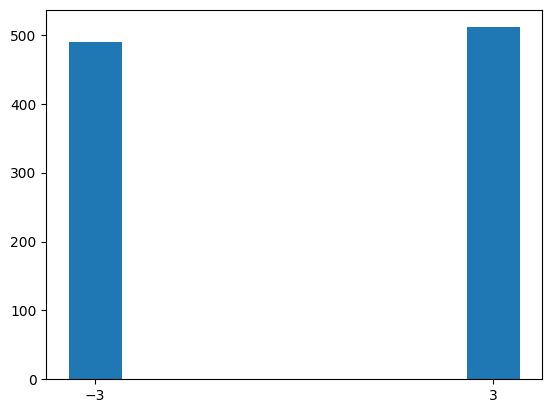

In [6]:
simulation_results = exercise_circuit()

labels, counts = np.unique(simulation_results[0]+simulation_results[1]+simulation_results[2], return_counts=True)
plt.bar(labels, counts, align='center')
plt.xticks(labels)

### Exercise 3: Optimization

Do the same optimization exercise for the GHZ circuit from Exercise one.

Choose a suitable ansatz and optimize parameters to obtain $\big|\ 000\big>$.

You can use the code from the optimization from above as a basis.

#### Solution

We build the same optimization circuit like for the Bell state.

In [7]:
dev = qml.device("lightning.qubit", wires=3)

def exercise_ansatz(params):
    qml.RY(params[0], wires=0)
    qml.RY(params[1], wires=1)
    qml.RY(params[2], wires=2)
    qml.RX(params[3], wires=0)
    qml.RX(params[4], wires=1)
    qml.RX(params[5], wires=2)
    qml.CNOT(wires=[1,0])
    qml.CNOT(wires=[2,1])
    qml.CNOT(wires=[0,2])
    qml.RX(params[6], wires=0)
    qml.RX(params[7], wires=1)
    qml.RX(params[8], wires=2)


@qml.qnode(dev)
def exercise_opt_circuit(params):
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0,1])
    qml.CNOT(wires=[1,2])
    exercise_ansatz(params)
    return [qml.expval(qml.PauliZ(i)) for i in [0,1,2]]

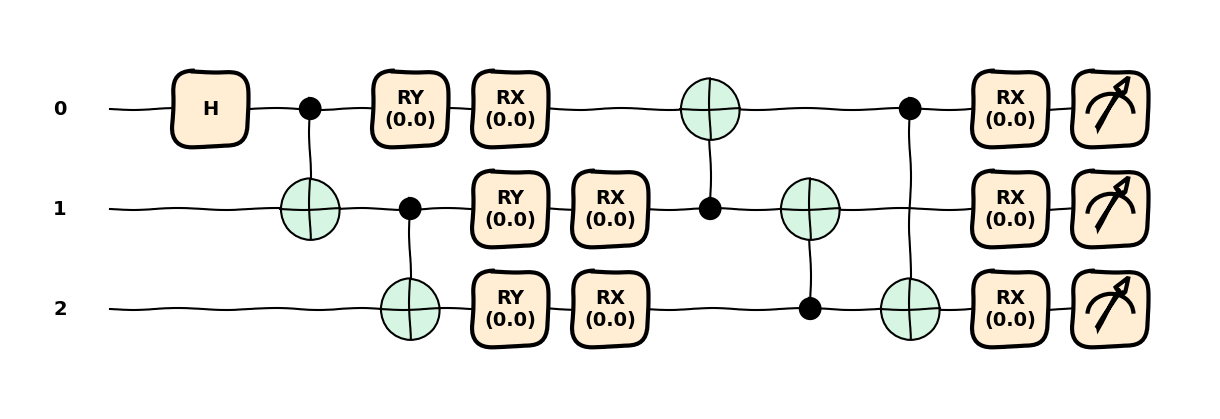

In [8]:
qml.draw_mpl(exercise_opt_circuit, decimals=1, style="sketch")(np.zeros(9))
plt.show()

As simple loss function we can again use the sum of the measurements of all qubits, since we want to converge to $\big| 000\big>$

In [9]:
def cost_exercise(params):
    return 1-sum(exercise_opt_circuit(params))/3

In [10]:
params = np.array(np.random.uniform(size=9), requires_grad=True)

In [11]:
opt = qml.AdamOptimizer(stepsize=0.01)

Running the training the loss converges to 0.

In [12]:
for i in range(300):
    params = opt.step(cost_exercise, params)

    if (i + 1) % 25 == 0:
        print("Cost after step {:5d}: {: .7f}".format(i + 1, cost_exercise(params)))

Cost after step    25:  0.5198704
Cost after step    50:  0.3858964
Cost after step    75:  0.3038024
Cost after step   100:  0.2117565
Cost after step   125:  0.0733702
Cost after step   150:  0.0151387
Cost after step   175:  0.0026034
Cost after step   200:  0.0002631
Cost after step   225:  0.0000085
Cost after step   250:  0.0000001
Cost after step   275:  0.0000001
Cost after step   300:  0.0000000


And as we can check we obtain $1$ from all measurements with the optimized parameters (which corresponds to the eigenstate $\big|0\big>$ in the Pauli Z basis.

In [13]:
exercise_opt_circuit(params)

[array(1.), array(1.), array(1.)]